## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-30px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
LOAD_WEIGHTS_FILE = None

BATCH_SIZE=24

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=False)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-16 04:07:59,336 INFO Output dirs created


### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2017-04-16 04:07:59,345 INFO Load CNN model


### Prepare train, validate and test data flows

In [5]:
OUTPUT_WEIGHT = (1,1,0,0,0,1)
TRAIN_EPOCHS = 20

logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

image_randomize_generator = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=360,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False)
train_balance_generator.setup_flow(0, 0.8)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_batch_generator.size) + ' batches=' + str(train_batch_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False)
valid_balance_generator.setup_flow(0.8, 0.1)
logger.info('valid size=' + str(valid_batch_generator.size) + ' batches=' + str(valid_batch_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False)
test_balance_generator.setup_flow(0.9, 1)
logger.info('test size=' + str(test_batch_generator.size) + ' batches=' + str(test_batch_generator.nr_batches))

2017-04-16 04:07:59,542 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-30px-84-84.h5 as input
2017-04-16 04:07:59,545 INFO preparing train data
2017-04-16 04:07:59,547 INFO loading input data for class distribution analysis...
2017-04-16 04:07:59,548 INFO > [started] generator dump...


74328/74328

2017-04-16 04:08:13,911 INFO > [done]    generator dump (14362.910 ms)
2017-04-16 04:08:13,949 INFO raw sample class distribution
2017-04-16 04:08:13,950 INFO 0: 4680
2017-04-16 04:08:13,952 INFO 1: 3534
2017-04-16 04:08:13,953 INFO 2: 17903
2017-04-16 04:08:13,955 INFO 3: 8577
2017-04-16 04:08:13,956 INFO 4: 6597
2017-04-16 04:08:13,957 INFO 5: 33037
2017-04-16 04:08:13,958 INFO overall output samples per class: 3534
2017-04-16 04:08:13,960 INFO augmentation/undersampling ratio per class
2017-04-16 04:08:13,961 INFO SETUP FLOW 0 1
2017-04-16 04:08:13,962 INFO output distribution
2017-04-16 04:08:13,963 INFO 0: 0.755128205128 (3534.0)
2017-04-16 04:08:13,964 INFO 1: 1.0 (3534.0)
2017-04-16 04:08:13,966 INFO 2: 0.0 (0.0)
2017-04-16 04:08:13,967 INFO 3: 0.0 (0.0)
2017-04-16 04:08:13,968 INFO 4: 0.0 (0.0)
2017-04-16 04:08:13,969 INFO 5: 0.106970971941 (3534.0)
2017-04-16 04:08:13,970 INFO output total size 10602.0
2017-04-16 04:08:13,972 INFO flow output size 10602
2017-04-16 04:08:13,973

74328/74328

2017-04-16 04:08:28,350 INFO > [done]    generator dump (14202.779 ms)
2017-04-16 04:08:28,388 INFO raw sample class distribution
2017-04-16 04:08:28,389 INFO 0: 4680
2017-04-16 04:08:28,390 INFO 1: 3534
2017-04-16 04:08:28,391 INFO 2: 17903
2017-04-16 04:08:28,393 INFO 3: 8577
2017-04-16 04:08:28,394 INFO 4: 6597
2017-04-16 04:08:28,395 INFO 5: 33037
2017-04-16 04:08:28,397 INFO overall output samples per class: 3534
2017-04-16 04:08:28,398 INFO augmentation/undersampling ratio per class
2017-04-16 04:08:28,399 INFO SETUP FLOW 0 1
2017-04-16 04:08:28,400 INFO output distribution
2017-04-16 04:08:28,402 INFO 0: 0.755128205128 (3534.0)
2017-04-16 04:08:28,403 INFO 1: 1.0 (3534.0)
2017-04-16 04:08:28,404 INFO 2: 0.0 (0.0)
2017-04-16 04:08:28,405 INFO 3: 0.0 (0.0)
2017-04-16 04:08:28,407 INFO 4: 0.0 (0.0)
2017-04-16 04:08:28,408 INFO 5: 0.106970971941 (3534.0)
2017-04-16 04:08:28,409 INFO output total size 10602.0
2017-04-16 04:08:28,410 INFO flow output size 10602
2017-04-16 04:08:28,411

74328/74328

2017-04-16 04:08:42,728 INFO > [done]    generator dump (14146.484 ms)
2017-04-16 04:08:42,766 INFO raw sample class distribution
2017-04-16 04:08:42,767 INFO 0: 4680
2017-04-16 04:08:42,768 INFO 1: 3534
2017-04-16 04:08:42,770 INFO 2: 17903
2017-04-16 04:08:42,771 INFO 3: 8577
2017-04-16 04:08:42,772 INFO 4: 6597
2017-04-16 04:08:42,773 INFO 5: 33037
2017-04-16 04:08:42,775 INFO overall output samples per class: 3534
2017-04-16 04:08:42,776 INFO augmentation/undersampling ratio per class
2017-04-16 04:08:42,777 INFO SETUP FLOW 0 1
2017-04-16 04:08:42,778 INFO output distribution
2017-04-16 04:08:42,779 INFO 0: 0.755128205128 (3534.0)
2017-04-16 04:08:42,781 INFO 1: 1.0 (3534.0)
2017-04-16 04:08:42,782 INFO 2: 0.0 (0.0)
2017-04-16 04:08:42,783 INFO 3: 0.0 (0.0)
2017-04-16 04:08:42,784 INFO 4: 0.0 (0.0)
2017-04-16 04:08:42,786 INFO 5: 0.106970971941 (3534.0)
2017-04-16 04:08:42,787 INFO output total size 10602.0
2017-04-16 04:08:42,788 INFO flow output size 10602
2017-04-16 04:08:42,789

In [6]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
#logger.info('x ' + str(np.shape(X_train)))
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

#for xs,ys in train_balance_generator.flow():
#    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
#    break

2017-04-16 04:08:42,963 INFO BALANCE GENERATOR DATA
2017-04-16 04:08:42,965 INFO > [started] generator dump...
2017-04-16 04:08:42,967 INFO starting new flow...
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2176/2120

2017-04-16 04:08:48,986 INFO > [done]    generator dump (6020.594 ms)
2017-04-16 04:08:48,987 INFO y (2120, 6)
2017-04-16 04:08:48,991 INFO [705 747   0   0   0 668]


## Train model

In [7]:
if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(WEIGHTS_FILE)

logger.info('Starting CNN training...')

history = model.fit_generator(train_generator,
              steps_per_epoch = train_balance_generator.nr_batches,
              nb_epoch = TRAIN_EPOCHS,
              callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
              validation_data = valid_balance_generator.flow(), 
              validation_steps = valid_balance_generator.nr_batches,
              verbose = 1)

if(SAVE_WEIGHTS_FILE!=None):
    logger.info('Saving last weights...')
    model.save_weights(SAVE_WEIGHTS_FILE)

2017-04-16 04:08:49,002 INFO Starting CNN training...
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=None, validation_steps=25, verbose=1, validation_data=<generator..., steps_per_epoch=34, epochs=3)`


Epoch 1/3


/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


33/34 [============================>.] - ETA: 2s - loss: 1.1596 - acc: 0.4479  

2017-04-16 04:10:09,138 INFO starting new flow...


34/34 [==============================] - 99s - loss: 1.1523 - acc: 0.4481 - val_loss: 0.8382 - val_acc: 0.5531
Epoch 2/3
34/34 [==============================] - 98s - loss: 0.7735 - acc: 0.6025 - val_loss: 0.6456 - val_acc: 0.6138

2017-04-16 04:13:45,439 INFO Saving last weights...


### Epoch accuracy/loss

2017-04-16 04:13:45,666 INFO Training info


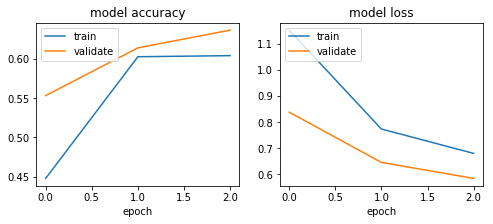

In [8]:
logger.info('Training info')
cnn.show_training_info_keras(history)

### Confusion matrix

2017-04-16 04:13:46,079 INFO Evaluating model performance (530 samples)...
2017-04-16 04:13:46,081 INFO starting new flow...
2017-04-16 04:13:53,871 INFO Accuracy: 0.612847222222 - Loss: 0.595971845918
2017-04-16 04:13:53,872 INFO Predicting Y for detailed analysis...
2017-04-16 04:14:02,588 INFO > [started] generator dump...


576/530

2017-04-16 04:14:03,581 INFO > [done]    generator dump (993.028 ms)
2017-04-16 04:14:03,583 INFO Nr test samples: 530|530
2017-04-16 04:14:03,585 INFO Kappa score (was this luck?): -0.0364579858028
2017-04-16 04:14:03,587 INFO Confusion matrix:
2017-04-16 04:14:03,588 INFO [[  8 107  77]
 [  4  74  57]
 [  3 133  67]]


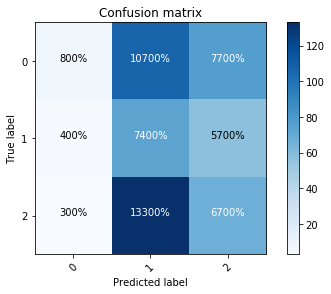

In [9]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=[0,1,2,3,4,5])

2017-04-16 04:17:38,476 INFO > [started] generator dump...
2017-04-16 04:17:38,478 INFO starting new flow...


64/24

2017-04-16 04:17:38,584 INFO > [done]    generator dump (108.014 ms)
2017-04-16 04:17:38,846 INFO showing 24 images
2017-04-16 04:17:38,848 INFO > [started] generating image patches. rows=3; cols=12...


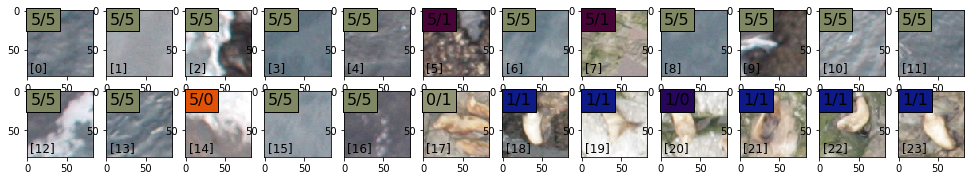

2017-04-16 04:17:41,532 INFO > [done]    generating image patches. rows=3; cols=12 (2683.313 ms)


In [11]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 24, model)
